In [1]:
import pandas as pd
import collections
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import matplotlib
import matplotlib.pyplot as plt
df = pd.read_csv('CA_user_reviews.csv')

In [3]:
import pandas as pd

# Assuming df is your DataFrame after reading from the CSV
# df = pd.read_csv('your_file.csv')

# Function to calculate daily hours
def calculate_daily_hours(hours_str):
    if hours_str:
        open_time, close_time = hours_str.split('-')
        open_hour, open_minute = map(int, open_time.split(':'))
        close_hour, close_minute = map(int, close_time.split(':'))
        
        # If closing time is earlier than opening time, it suggests the business closes after midnight
        if close_hour < open_hour or (close_hour == open_hour and close_minute < open_minute):
            close_hour += 24
        
        daily_hours = (close_hour - open_hour) + (close_minute - open_minute) / 60
        return max(0, daily_hours)  # Ensure that hours are not negative
    return 0

# Function to calculate the total weekly hours
def calculate_total_weekly_hours(hours_dict):
    total_hours = 0
    for day_hours in hours_dict.values():
        total_hours += calculate_daily_hours(day_hours)
    return total_hours

# Convert 'hours' column to dictionary and calculate 'total_hours'
df['hours_dict'] = df['hours'].apply(lambda x: eval(x) if pd.notnull(x) else {})
df['total_hours'] = df['hours_dict'].apply(calculate_total_weekly_hours)

# Now you can drop the 'hours_dict' column if it's no longer needed
# df = df.drop('hours_dict', axis=1)


In [4]:
unique_wifi_values = df['attributes'].apply(lambda attrs: attrs.get('WiFi') if isinstance(attrs, dict) else None).unique()

# Updated function to correctly parse the WiFi attribute based on its unique values
def extract_wifi_value(attributes):
    # If attributes is None or not a dictionary, return 0
    if not isinstance(attributes, dict):
        return 0
    # Get the WiFi value, handle both unicode and regular strings, and None types
    wifi_value = attributes.get('WiFi', 'u\'no\'').strip("u").strip("'")
    # Return 1 for 'free' or 'paid', 0 otherwise
    return 1 if wifi_value in ['free', 'paid'] else 0

# Apply the updated function to the WiFi column
df['WiFi'] = df['attributes'].apply(extract_wifi_value)

# Now let's also update the code to drop columns with sum of 0, excluding non-numeric ones
# Identify numeric columns to drop where the sum is 0
numeric_columns = df.select_dtypes(include=['number']).columns
columns_to_drop = [column for column in numeric_columns if df[column].sum() == 0]

# Drop the identified columns
df.drop(columns=columns_to_drop, inplace=True)

# Display the updated dataframe to verify the WiFi column and the dropped columns
df.head()



,Unnamed: 0,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,text,date,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,hours_dict,total_hours
0,0,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1.0,1.0,0.0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,...,0,0,0,0,0,0,0,0,{},0.0
1,1,9ag-bC-521T1i3IypXr4Ug,sx_cqxyWRUoOIoy_AXmLdQ,B5XSoSG3SfvQGtKEGQ1tSQ,4.0,1.0,0.0,0.0,I work with a college group that does camping ...,2013-09-07 21:16:36,...,0,0,9,12,11,11,11,0,{},0.0
2,2,SP736Ciz9njLZiwZCR3QnQ,sx_cqxyWRUoOIoy_AXmLdQ,5bDjg02rlg6ODEUT-UQT-A,3.0,3.0,1.0,1.0,Was hoping for a lot more! Got the filet migno...,2013-08-17 00:28:53,...,0,0,9,12,11,11,11,0,"{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22...",25.0
3,3,mGuEEBKBvxasUCkd59v1dg,sx_cqxyWRUoOIoy_AXmLdQ,_QohBRBxWuwlIUuHj5_fZQ,3.0,1.0,0.0,1.0,"I mean, you can't beat the views, that much is...",2013-08-17 00:35:27,...,0,0,9,12,11,11,11,0,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",0.0
4,4,fYSB2HqxJqEGUJh2eka9KA,sx_cqxyWRUoOIoy_AXmLdQ,yPSejq3_erxo9zdVYTBnZA,5.0,0.0,0.0,0.0,One of my favorite spots when visiting Santa B...,2013-08-17 00:37:43,...,0,0,9,12,11,11,11,0,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",70.0


In [5]:
numeric_columns = df.select_dtypes(include='number').columns

# Identify columns to drop where the sum is 0
columns_to_drop = [column for column in numeric_columns if df[column].sum() == 0]

# Drop the identified columns
df.drop(columns=columns_to_drop, inplace=True)

# Display the updated dataframe to verify the columns have been dropped
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,text,date,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,hours_dict,total_hours
0,0,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1.0,1.0,0.0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,...,0,0,0,0,0,0,0,0,{},0.0
1,1,9ag-bC-521T1i3IypXr4Ug,sx_cqxyWRUoOIoy_AXmLdQ,B5XSoSG3SfvQGtKEGQ1tSQ,4.0,1.0,0.0,0.0,I work with a college group that does camping ...,2013-09-07 21:16:36,...,0,0,9,12,11,11,11,0,{},0.0
2,2,SP736Ciz9njLZiwZCR3QnQ,sx_cqxyWRUoOIoy_AXmLdQ,5bDjg02rlg6ODEUT-UQT-A,3.0,3.0,1.0,1.0,Was hoping for a lot more! Got the filet migno...,2013-08-17 00:28:53,...,0,0,9,12,11,11,11,0,"{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22...",25.0
3,3,mGuEEBKBvxasUCkd59v1dg,sx_cqxyWRUoOIoy_AXmLdQ,_QohBRBxWuwlIUuHj5_fZQ,3.0,1.0,0.0,1.0,"I mean, you can't beat the views, that much is...",2013-08-17 00:35:27,...,0,0,9,12,11,11,11,0,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",0.0
4,4,fYSB2HqxJqEGUJh2eka9KA,sx_cqxyWRUoOIoy_AXmLdQ,yPSejq3_erxo9zdVYTBnZA,5.0,0.0,0.0,0.0,One of my favorite spots when visiting Santa B...,2013-08-17 00:37:43,...,0,0,9,12,11,11,11,0,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",70.0


In [6]:
df['Mexican'] = df['categories'].str.contains("Mexican", case=False, na=False).astype(int)
df['Breakfast & Brunch'] = df['categories'].str.contains("Breakfast & Brunch", case=False, na=False).astype(int)
df['Vegetarian'] = df['categories'].str.contains("Vegetarian", case=False, na=False).astype(int)
df['Sandwiches'] = df['categories'].str.contains("Sandwiches", case=False, na=False).astype(int)
df['Coffee & Tea'] = df['categories'].str.contains("Coffee & Tea", case=False, na=False).astype(int)
df['Burgers'] = df['categories'].str.contains("Burgers", case=False, na=False).astype(int)
df['Pizza'] = df['categories'].str.contains("Pizza", case=False, na=False).astype(int)
df['Cafes'] = df['categories'].str.contains("Cafes", case=False, na=False).astype(int)
df['Bakeries'] = df['categories'].str.contains("Bakeries", case=False, na=False).astype(int)
df['Steakhouse'] = df['categories'].str.contains("Steakhouse", case=False, na=False).astype(int)
df['Seafood'] = df['categories'].str.contains("Seafood", case=False, na=False).astype(int)
df

,Unnamed: 0,review_id,user_id,business_id,stars_x,useful_x,funny_x,cool_x,text,date,...,Breakfast & Brunch,Vegetarian,Sandwiches,Coffee & Tea,Burgers,Pizza,Cafes,Bakeries,Steakhouse,Seafood
0,0,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1.0,1.0,0.0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,...,0,0,0,0,0,0,0,0,0,0
1,1,9ag-bC-521T1i3IypXr4Ug,sx_cqxyWRUoOIoy_AXmLdQ,B5XSoSG3SfvQGtKEGQ1tSQ,4.0,1.0,0.0,0.0,I work with a college group that does camping ...,2013-09-07 21:16:36,...,0,0,0,0,0,0,0,0,0,0
2,2,SP736Ciz9njLZiwZCR3QnQ,sx_cqxyWRUoOIoy_AXmLdQ,5bDjg02rlg6ODEUT-UQT-A,3.0,3.0,1.0,1.0,Was hoping for a lot more! Got the filet migno...,2013-08-17 00:28:53,...,0,0,0,0,0,0,0,0,1,1
3,3,mGuEEBKBvxasUCkd59v1dg,sx_cqxyWRUoOIoy_AXmLdQ,_QohBRBxWuwlIUuHj5_fZQ,3.0,1.0,0.0,1.0,"I mean, you can't beat the views, that much is...",2013-08-17 00:35:27,...,0,0,0,0,0,0,0,0,0,0
4,4,fYSB2HqxJqEGUJh2eka9KA,sx_cqxyWRUoOIoy_AXmLdQ,yPSejq3_erxo9zdVYTBnZA,5.0,0.0,0.0,0.0,One of my favorite spots when visiting Santa B...,2013-08-17 00:37:43,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348850,348850,g7q22jHG6Vi6ANDuBCThWQ,P7U5QFaP3JkJ7KbE2FgzUg,z-dnUiZVUWnDyZgqGVHCEw,5.0,1.0,0.0,0.0,Stop by here all the time. Awsome customer se...,2016-08-30 19:51:48,...,0,0,0,0,0,0,0,0,0,0
348851,348851,FtFJU5Avz7wzlqLYquZcvg,g48tDWwqDw-SQfaCPJDZUw,z-dnUiZVUWnDyZgqGVHCEw,1.0,0.0,0.0,0.0,These guys falsely advertised and stole money ...,2021-03-24 21:44:27,...,0,0,0,0,0,0,0,0,0,0
348852,348852,cKuP5pnvbvpn4UbaccVcdg,OVYb1El25BgVhgbXb4e-KA,XPkkWyAkkPeH-PqXmBMmpg,5.0,0.0,0.0,0.0,Great experience with great people who are rea...,2021-06-22 21:41:07,...,0,0,0,0,0,0,0,0,0,0
348853,348853,dZC87sZ1f2ntOf876_DDLg,9w5PoliouEyNikdy6DizqQ,XPkkWyAkkPeH-PqXmBMmpg,5.0,0.0,0.0,0.0,I spent the week in Santa Barbara and had the ...,2021-06-28 23:53:44,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars_x',
       'useful_x', 'funny_x', 'cool_x', 'text', 'date', 'name_x', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars_y',
       'review_count_x', 'is_open', 'attributes', 'categories', 'hours',
       'name_y', 'review_count_y', 'yelping_since', 'useful_y', 'funny_y',
       'cool_y', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'hours_dict', 'total_hours', 'Mexican',
       'Breakfast & Brunch', 'Vegetarian', 'Sandwiches', 'Coffee & Tea',
       'Burgers', 'Pizza', 'Cafes', 'Bakeries', 'Steakhouse', 'Seafood'],
      dtype='object')

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
# One-hot encode the 'city' column
encoder = OneHotEncoder(sparse=False)
city_encoded = encoder.fit_transform(df[['city']])
# Check for the appropriate method based on the version of scikit-learn
if hasattr(encoder, 'get_feature_names_out'):
    city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names_out(['city']))
else:
    city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names(['city']))
# ...


# Selecting the specified features
features = ['Mexican', 'Breakfast & Brunch', 'Vegetarian', 'Sandwiches', 'Coffee & Tea',
            'Burgers', 'Pizza', 'Cafes', 'Bakeries', 'Steakhouse', 'Seafood', 'total_hours']
X = df[features].join(city_encoded_df) # Joining the binary features with the one-hot encoded city data

# Target variable
y = df['stars_y']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients from the model
coefficients = model.coef_

# For one-hot encoded features, sum the absolute value of coefficients for each original feature
# Assuming that the one-hot encoded columns are at the end of X_train
original_feature_names = features  # The original non-encoded feature names
encoded_feature_names = city_encoded_df.columns.tolist()  # The one-hot encoded feature names

# Map each one-hot encoded feature name back to the original feature name
mapping = {encoded_feature: original for original in original_feature_names for encoded_feature in encoded_feature_names if original in encoded_feature}

# Initialize a dictionary to store the summed importance of each original feature
feature_importance = {original: 0 for original in original_feature_names}

# Sum the absolute values of coefficients for each original feature
for encoded_feature, coefficient in zip(X_train.columns, coefficients):
    # If the feature is one-hot encoded, add its importance to its original feature
    if encoded_feature in mapping:
        feature_importance[mapping[encoded_feature]] += abs(coefficient)
    # Else, it's a regular feature, add its importance directly
    else:
        feature_importance[encoded_feature] = abs(coefficient)

# Sort features by their importance
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# Display the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Summed Importance: {importance}")


# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"Test Accuracy (R-squared Score): {r2}")

c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Feature: city_Spring Hill, Summed Importance: 1179038782.6528559
Feature: city_Ventura, Summed Importance: 1179038782.2388608
Feature: city_Real Goleta, Summed Importance: 1179038781.7386084
Feature: city_SANTA BARBARA AP, Summed Importance: 1179038781.6197624
Feature: city_Santa Clara, Summed Importance: 1179038781.604899
Feature: city_Port Hueneme, Summed Importance: 1179038781.0917892
Feature: city_Cerritos, Summed Importance: 1179038780.6127808
Feature: city_Costa Mesa, Summed Importance: 1179038780.216133
Feature: city_Valencia, Summed Importance: 1179038780.168827
Feature: city_Santa Barbara & Ventura Counties, Summed Importance: 1179038780.1573339
Feature: city_Salinas, Summed Importance: 1179038780.1182272
Feature: city_Santa Barbra, Summed Importance: 1179038779.9561763
Feature: city_Goleta, Summed Importance: 1179038779.9033375
Feature: city_Isla Vista, Summed Importance: 1179038779.8971817
Feature: city_Carpinteria, Summed Importance: 1179038779.768453
Feature: city_Santa  B

In [9]:
# Defining the features and target variable
import numpy as np

features = ['Mexican', 'Breakfast & Brunch', 'Vegetarian', 'Sandwiches', 'Coffee & Tea',
            'Burgers', 'Pizza', 'Cafes', 'Bakeries', 'Steakhouse', 'Seafood', 'total_hours', 'city']
X = df[features]
y = df['stars_y']

# Define a pipeline to handle preprocessing and regression
# This will ensure that preprocessing occurs within each fold of the cross-validation
numeric_features = ['total_hours']
categorical_features = ['city']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # or another scaler if more appropriate
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append regressor to preprocessing pipeline
# Now we have a full prediction pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

# Define the k-fold cross-validation procedure
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Perform the k-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')

# Calculate the RMSE for each fold
rmse_scores = np.sqrt(-cv_scores)

# Output the scores
print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

RMSE for each fold: [0.65757807 0.65203615 0.65690847 0.65316524 0.65569054]
Average RMSE: 0.6550756943934817
Standard Deviation of RMSE: 0.002139515949738832


In [26]:
import pandas as pd
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import elu
import keras

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense


# Assuming 'df' is your DataFrame and is already loaded

# Handling missing values (simple approach)
df.fillna(0, inplace=True)

# Define the features and target variable
numeric_features = ['total_hours']
categorical_features = ['city']
binary_features = ['Mexican', 'Breakfast & Brunch', 'Vegetarian', 'Sandwiches', 'Coffee & Tea',
                   'Burgers', 'Pizza', 'Cafes', 'Bakeries', 'Steakhouse', 'Seafood']
target_variable = ['stars_y']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the features
X = preprocessor.fit_transform(df[binary_features + numeric_features + categorical_features])
y = df[target_variable].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Sequential model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Linear activation for a single regression output

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model
model.fit(X_train.toarray(), np.array(y_train), epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {mse}")


Epoch 1/100

6978/6978 [==============================] - 18s 2ms/step - loss: 0.4446 - val_loss: 0.4357
Epoch 2/100
6978/6978 [==============================] - 17s 2ms/step - loss: 0.3946 - val_loss: 0.3992
Epoch 3/100
6977/6978 [============================>.] - ETA: 0s - loss: 0.3914

KeyboardInterrupt: 

In [23]:
X_train

<279084x40 sparse matrix of type '<class 'numpy.float64'>'
	with 558168 stored elements in Compressed Sparse Row format>

In [20]:
pd.DataFrame(X_train).shape, np.array(y_train).shape

((279084, 1), (279084, 1))

In [13]:
y_train.shape

(279084, 1)

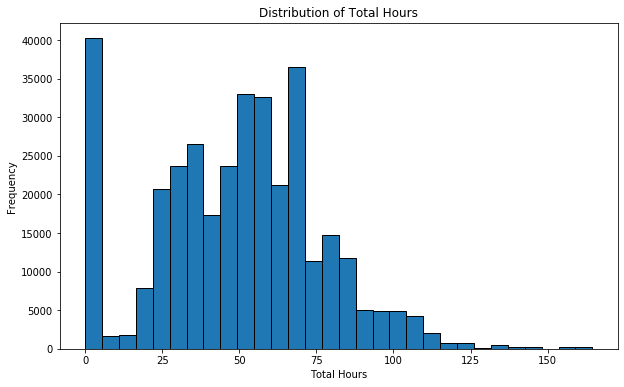

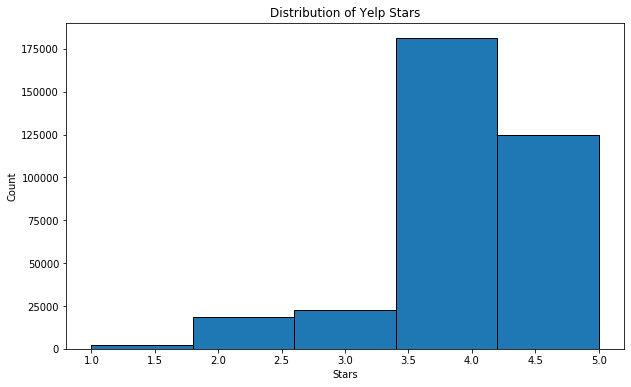

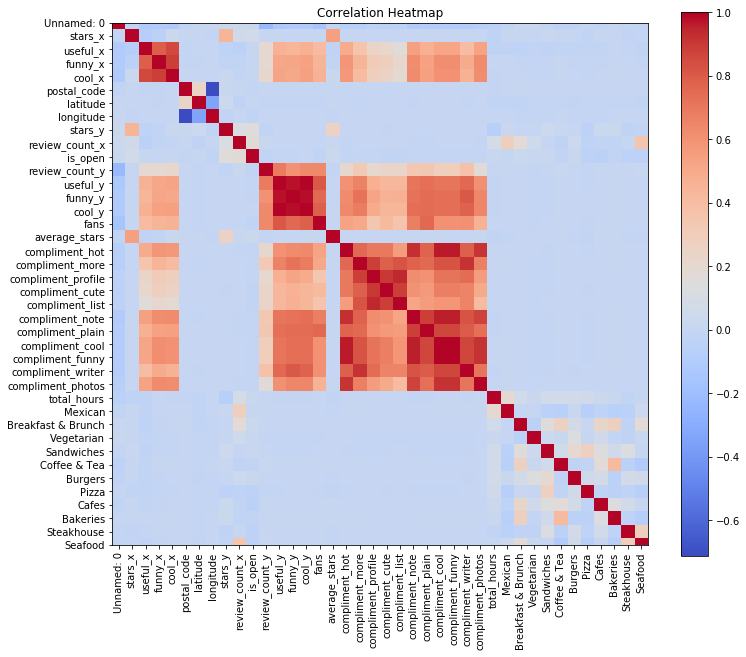

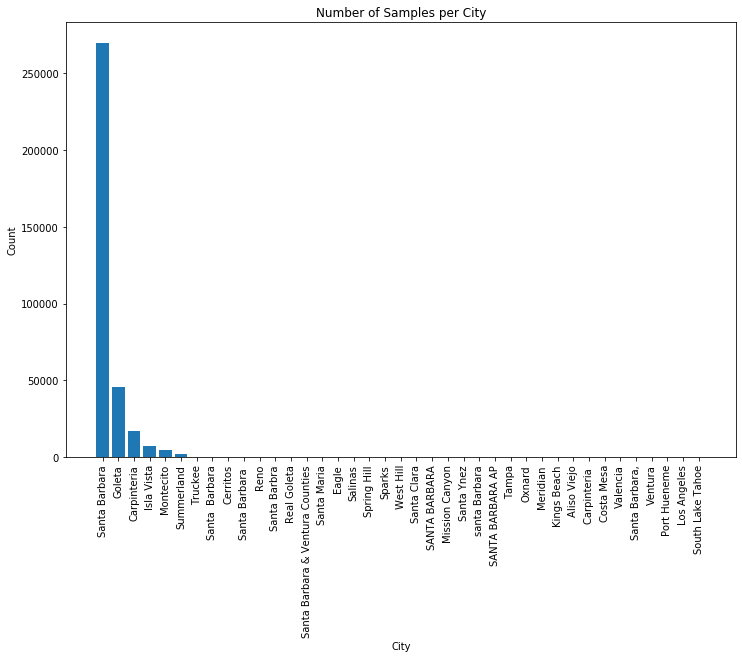

NameError: name 'predicted_values' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'total_hours' column exists
plt.figure(figsize=(10, 6))
plt.hist(df['total_hours'], bins=30, edgecolor='black')
plt.title('Distribution of Total Hours')
plt.xlabel('Total Hours')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['stars_y'], bins=5, edgecolor='black')  # Yelp ratings typically have 5 classes
plt.title('Distribution of Yelp Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

import numpy as np

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Correlation Heatmap')
plt.show()

city_counts = df['city'].value_counts()

plt.figure(figsize=(12, 8))
plt.bar(city_counts.index, city_counts.values)
plt.title('Number of Samples per City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate the city names for better readability
plt.show()

# Assuming 'y_test' and 'predicted_values' are defined
residuals = y_test - predicted_values

plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Assuming 'y_test' and 'predicted_values' are defined
residuals = y_test - predicted_values

plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Assuming 'model' is a trained linear regression model and 'X_train' is your training dataset
feature_importance = model.coef_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()


In [ ]:
df['total_hours'].unique()

array([   0.        ,   25.        ,   70.        ,   67.        ,
         24.        ,   57.        ,   55.        ,   38.        ,
         63.        ,   74.        ,   28.        ,   40.        ,
         62.5       ,   47.        ,   91.        ,   35.        ,
         36.        ,   32.        ,   62.        ,   52.5       ,
         84.        ,  112.        ,   60.        ,   45.        ,
         42.25      ,   41.        ,   33.        ,   38.25      ,
         30.        ,   39.        ,   43.        ,   23.5       ,
          5.        ,   53.        ,  105.        ,    9.25      ,
        -59.5       ,   21.        ,  100.5       ,   49.        ,
        -66.5       ,   54.5       ,   69.5       ,   54.        ,
         57.5       ,   82.5       ,  -68.5       ,  -98.        ,
        -78.        ,   44.        ,   29.        ,   52.        ,
        -89.5       ,   64.        ,   27.5       ,   58.5       ,
         76.        ,   82.        ,   71.        ,   75.5    

In [ ]:
df.to_csv('D:\CA_user_reviews.csv/my_dataframe.csv', index=False)